**Bước 1: Chuẩn Bị Dữ Liệu**

In [1]:
# Clone the dataset repository
!git clone https://github.com/TrucTranTrung/Emotions_Reconition_Through_Sound_Data.git

Cloning into 'Emotions_Reconition_Through_Sound_Data'...
remote: Enumerating objects: 1525, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 1525 (delta 18), reused 53 (delta 18), pack-reused 1472 (from 1)
Receiving objects: 100% (1525/1525), 279.06 MiB | 33.27 MiB/s, done.
Resolving deltas: 100% (258/258), done.
Updating files: 100% (1455/1455), done.


In [2]:
!pip install torchinfo
!pip install torchviz 

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=5684669e50d38eb055f3d652d76b3c497a7ade3f5895eb0616e512b3ae25df8d
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


**Bước 2: Tiền Xử Lý Dữ Liệu Âm Thanh**

In [3]:
import os
import librosa
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Các tham số chung
n_fft = 2048        # Kích thước của FFT (số mẫu trong mỗi cửa sổ)
hop_length = 512    # Bước nhảy giữa các cửa sổ (số mẫu)
n_mels = 128        # Số lượng Mel bands
n_mfcc = 41         # Số lượng hệ số MFCC

# Hàm trích xuất nhãn cảm xúc từ tên file
def extract_label(file_name):
    emotion = int(file_name.split("-")[2])  # Vị trí thứ 3 chứa nhãn cảm xúc
    return emotion - 1  # Chuyển thành nhãn bắt đầu từ 0

# Hàm chuẩn hóa thời gian về 3 giây và trim khoảng lặng
def preprocess_audio(audio_path, target_duration=3, sr=22050):
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Trim khoảng lặng ở đầu và cuối
    y, _ = librosa.effects.trim(y)
    
    # Chuẩn hóa độ dài âm thanh về 3 giây (trường hợp âm thanh dài hơn hoặc ngắn hơn)
    target_length = target_duration * sr
    if len(y) > target_length:
        y = y[:target_length]
    else:
        padding = target_length - len(y)
        y = np.pad(y, (0, padding), mode='constant')
    
    return y, sr

# Hàm trích xuất MFCC từ dữ liệu âm thanh đã được chuẩn hóa
def extract_mfcc(audio_path, n_mfcc=40, target_duration=3, sr=22050):
    y, sr = preprocess_audio(audio_path, target_duration, sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

# Hàm trích xuất tất cả các đặc trưng
def extract_all_features(y, sr, n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length):
    # Trích xuất các đặc trưng từ âm thanh đã được chuẩn hóa
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    
    # Kết hợp các đặc trưng theo trục đặc trưng
    combined_features = np.hstack([mfcc.T, chroma.T, mel_spectrogram_db.T, spectral_centroid.T, spectral_bandwidth.T, spectral_contrast.T, spectral_rolloff.T, rms.T])
    
    return combined_features
# Đường dẫn đến thư mục chứa dữ liệu
data_path = '/kaggle/working/Emotions_Reconition_Through_Sound_Data/Data-set/Sound_Expression/audio_speech_actors_01-24'

# Khởi tạo danh sách lưu đặc trưng và nhãn
features = []
labels = []

# Lặp qua tất cả các file âm thanh trong thư mục
for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav') or file_name.endswith('.mp3'):
            y, sr = preprocess_audio(os.path.join(folder_path, file_name))
#             mfcc = extract_mfcc(os.path.join(folder_path, file_name))
            combined_features = extract_all_features(y, sr, n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
            label = extract_label(file_name)
            features.append(combined_features)
            labels.append(label)

# Chuẩn hóa đặc trưng MFCC
scaler = StandardScaler()
features = [scaler.fit_transform(f) for f in features]

# Chia dữ liệu thành tập train, val, test theo tỷ lệ 8:1:1

X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Bước 3: Xây Dựng Mô Hình Transformer cho Nhận Diện Cảm Xúc**

**Bước 3.1:Xây Dựng Mô Hình Transformer**

In [4]:
import torch.nn as nn

class EmotionTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, nhead=4, num_encoder_layers=2, max_len=130): 
        super(EmotionTransformer, self).__init__()
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len + 1, input_dim))  # max_len + 1 cho token [CLS]
        encoder_layers = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        
        self.fc = nn.Linear(input_dim, num_classes)
    
    def forward(self, src):
        batch_size = src.size(0)
        cls_token = torch.zeros((batch_size, 1, src.size(-1)), device=src.device)  # Tạo token [CLS] với cùng batch_size và d_model
        src = torch.cat((cls_token, src), dim=1)  # Thêm [CLS] vào đầu chuỗi ở chiều thứ 1 (chiều sequence)
        
        src += self.positional_encoding[:, :src.size(1)].to(src.device)
        
        transformer_output = self.transformer_encoder(src)
        cls_output = transformer_output[:, 0, :]  # Lấy kết quả của token [CLS]
        output = self.fc(cls_output)
        
        return output

# Kiểm tra xem có GPU không và chuyển mô hình sang GPU nếu có
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

input_dim = X_train[0].shape[1]  # Số lượng đặc trưng MFCC
num_classes = len(set(labels))  # Số lượng nhãn cảm xúc
max_len = X_train[0].shape[0]
print(input_dim)
model = EmotionTransformer(input_dim=input_dim, num_classes=num_classes, max_len=max_len).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Training on device: cuda
192


**Bước 3.2 chuyển dữ liệu sang tensor**

In [5]:
from torch.utils.data import DataLoader, TensorDataset

# Định nghĩa thiết bị (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chuyển đổi dữ liệu thành tensor và đưa lên GPU
X_train = torch.stack([torch.tensor(f, dtype=torch.float32) for f in X_train]).to(device)
X_val = torch.stack([torch.tensor(f, dtype=torch.float32) for f in X_val]).to(device)
X_test = torch.stack([torch.tensor(f, dtype=torch.float32) for f in X_test]).to(device)

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Định nghĩa batch size
batch_size = 32

# Tạo TensorDataset và DataLoader cho tập train, val, test
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Kiểm tra kích thước các tập dữ liệu
print(f'Số lượng mẫu trong tập train: {len(train_loader.dataset)}')
print(f'Số lượng mẫu trong tập val: {len(val_loader.dataset)}')
print(f'Số lượng mẫu trong tập test: {len(test_loader.dataset)}')

# Xác định max_len từ số lượng khung thời gian của một mẫu trong X_train
max_len = X_train.size(1)
print(f'Maximum sequence length (max_len): {max_len}')


Số lượng mẫu trong tập train: 1152
Số lượng mẫu trong tập val: 144
Số lượng mẫu trong tập test: 144
Maximum sequence length (max_len): 130


**Bước 3.2: in ra thông số của model**

In [6]:
from torchinfo import summary
sample_spectrogram = X_train[0]
sample_input = sample_spectrogram.unsqueeze(0).to(device)
# Kiểm tra kích thước tensor qua các lớp
print(f"Sample input {sample_input.size()}")
print(summary(model, input_size=sample_input.size()))

Sample input torch.Size([1, 130, 192])
Layer (type:depth-idx)                        Output Shape              Param #
EmotionTransformer                            [1, 8]                    25,152
├─TransformerEncoder: 1-1                     [1, 131, 192]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 131, 192]             937,664
│    │    └─TransformerEncoderLayer: 3-2      [1, 131, 192]             937,664
├─Linear: 1-2                                 [1, 8]                    1,544
Total params: 1,902,024
Trainable params: 1,902,024
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.11


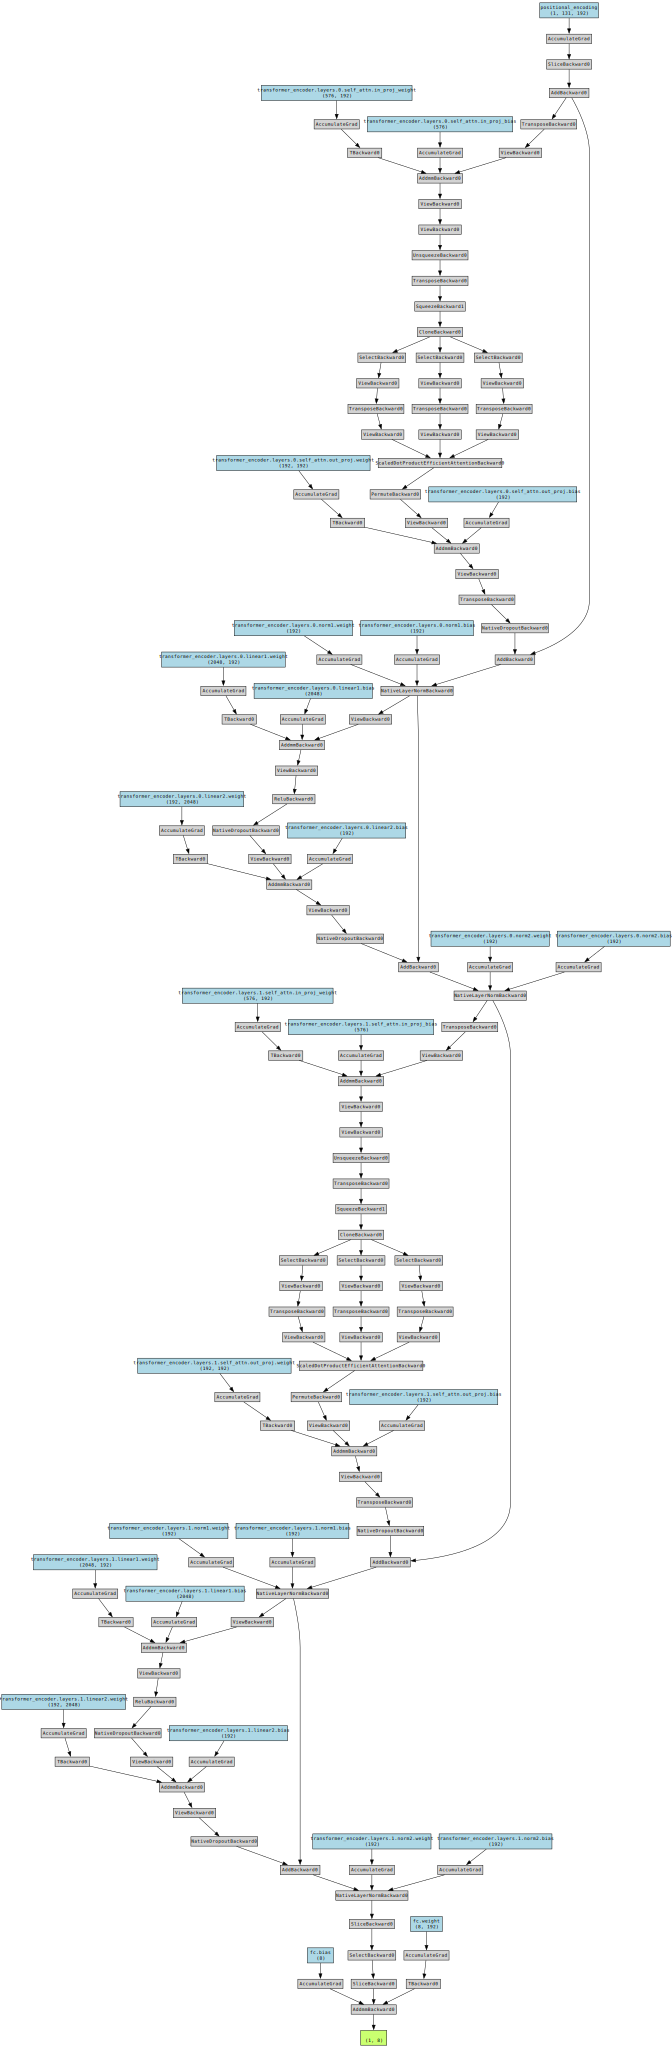

In [7]:
import torch
from torchviz import make_dot

# Chạy mô hình với một input mẫu
sample_spectrogram = X_train[0]  # Lấy một mẫu từ X_train
sample_input = sample_spectrogram.unsqueeze(0).to(device)  # Thêm chiều batch và chuyển lên GPU nếu có

# Tạo đồ thị của mô hình bằng cách chạy forward
output = model(sample_input)
dot = make_dot(output, params=dict(model.named_parameters()))

# Hiển thị đồ thị
dot.render("model_visualization", format="png")  # Lưu dưới dạng file PNG
dot  # Hiển thị đồ thị ngay trong notebook

**Bước 4: Huấn Luyện Mô Hình và Lưu Trọng Số Tốt Nhất**


**4.1. Huấn Luyện Mô Hình và Lưu Trọng Số Tốt Nhất theo Validation**

In [8]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy =0

num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    # Training loop
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        
        inputs = inputs.to(device)  # Chuyển đổi đầu vào thành dạng (batch_size, sequence_length, d_model)
        targets = targets.to(device)  # Chuyển đổi target thành dạng (batch_size)
        
        outputs = model(inputs)  # outputs có kích thước (batch_size, num_classes)
        loss = criterion(outputs, targets)  # criterion yêu cầu outputs có kích thước (batch_size, num_classes) và targets có kích thước (batch_size)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)  # Tổng loss cho toàn bộ batch
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    
    train_losses.append(train_loss / total_train)
    train_accuracies.append(correct_train / total_train)
    
    # Validation loop
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
    
    val_losses.append(val_loss / total_val)
    val_accuracies.append(correct_val / total_val)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')
    
    # Ưu tiên lưu mô hình tốt nhất dựa trên val_accuracy
    if val_accuracies[-1] > best_val_accuracy:
        best_val_accuracy = val_accuracies[-1]
        torch.save(model.state_dict(), 'best_emotion_transformer_ravdess.pth')
    
    # Nếu val_accuracy không cải thiện, lưu mô hình dựa trên val_loss
    elif (val_accuracies[-1]==best_val_accuracy) & (val_losses[-1] < best_val_loss):
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), 'best_emotion_transformer_ravdess.pth')

Epoch [1/150], Train Loss: 2.2256, Val Loss: 2.0808
Train Accuracy: 0.1398, Val Accuracy: 0.1597
Epoch [2/150], Train Loss: 2.0474, Val Loss: 1.9008
Train Accuracy: 0.1632, Val Accuracy: 0.2639
Epoch [3/150], Train Loss: 1.8597, Val Loss: 1.8257
Train Accuracy: 0.2656, Val Accuracy: 0.2083
Epoch [4/150], Train Loss: 1.7472, Val Loss: 1.7836
Train Accuracy: 0.2951, Val Accuracy: 0.2708
Epoch [5/150], Train Loss: 1.6339, Val Loss: 1.5752
Train Accuracy: 0.3594, Val Accuracy: 0.3958
Epoch [6/150], Train Loss: 1.4896, Val Loss: 1.5721
Train Accuracy: 0.4132, Val Accuracy: 0.3750
Epoch [7/150], Train Loss: 1.3988, Val Loss: 1.5071
Train Accuracy: 0.4566, Val Accuracy: 0.4097
Epoch [8/150], Train Loss: 1.2800, Val Loss: 1.4438
Train Accuracy: 0.5122, Val Accuracy: 0.4514
Epoch [9/150], Train Loss: 1.1489, Val Loss: 1.7334
Train Accuracy: 0.5720, Val Accuracy: 0.4097
Epoch [10/150], Train Loss: 1.1256, Val Loss: 1.4175
Train Accuracy: 0.5686, Val Accuracy: 0.4792
Epoch [11/150], Train Loss: 1

**Bước 5: Đánh Giá Trên Tập Test Sử Dụng Mô Hình Tốt Nhất trên GPU**

In [9]:
# Load mô hình tốt nhất
model.load_state_dict(torch.load('best_emotion_transformer_ravdess.pth'))
model.to(device)

# Đánh giá trên tập test
model.eval()
correct_test = 0
total_test = 0
test_loss = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        correct_test += (predicted == targets).sum().item()
        total_test += targets.size(0)

test_accuracy = correct_test / total_test
test_loss = test_loss / total_test

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 1.7274, Test Accuracy: 0.6944


**Bước 6: Vẽ Biểu Đồ Train và Validation Loss, Accuracy**

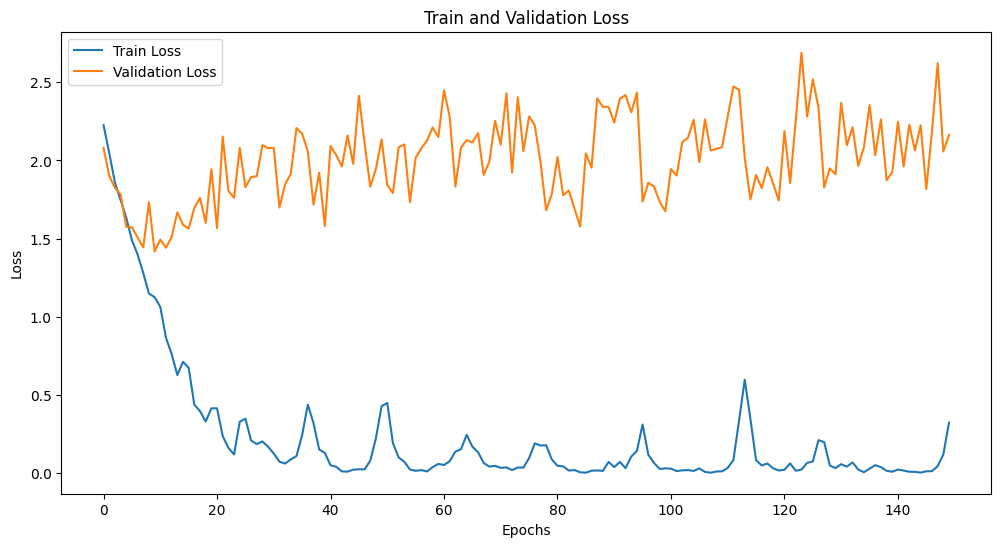

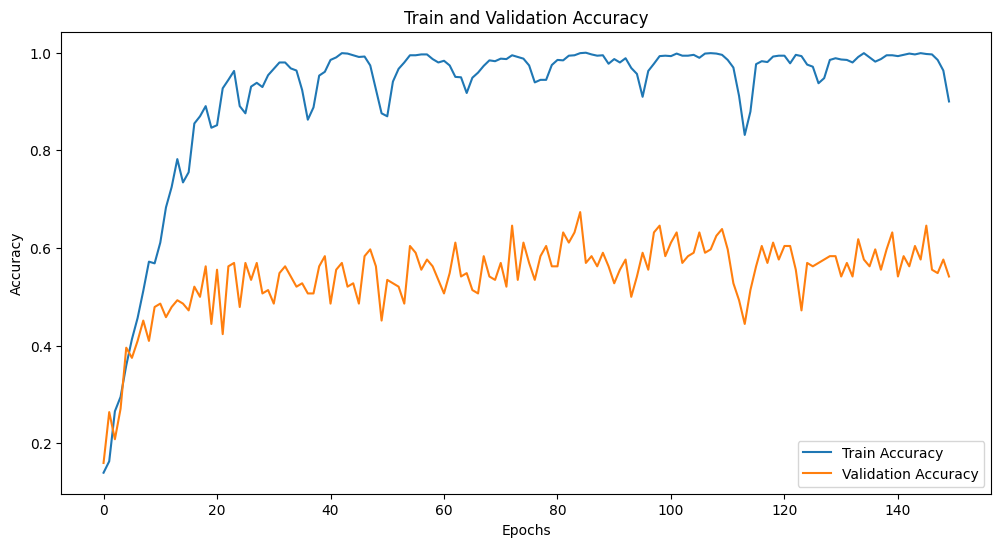

In [10]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()
